<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# Getting Started on LLM Classification Fine Tuning with [KerasNLP](https://github.com/keras-team/keras-nlp) and [Keras](https://github.com/keras-team/keras)

<div align="center">
    <img src="https://i.ibb.co/wJMF5HL/lmsys.png">
</div>

In this competition, our aim is to predict which LLM responses users will prefer in a head-to-head battle between chatbots powered by large language models (LLMs). In other words, the goal of the competition is to predict the preferences of the judges and determine the likelihood that a given prompt/response pair is selected as the winner. This notebook will guide you through the process of fine-tuning the **DebertaV3** model for this competition using the **Shared Weight** strategy with KerasNLP. This strategy is similar to how Multiple Choice Question (MCQ) models are trained. Additionally, we will use mixed precision for faster training and inference.

**Did you know**: This notebook is backend-agnostic, which means it supports TensorFlow, PyTorch, and JAX backends. However, the best performance can be achieved with `JAX`. KerasNLP and Keras enable the choice of the preferred backend. Explore further details on [Keras](https://keras.io/keras_3/).

**Note**: For a deeper understanding of KerasNLP, refer to the [KerasNLP guides](https://keras.io/keras_nlp/).


# 📚 | Import Libraries

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive
import os
drive_path = '/content/drive/MyDrive/NLP/Final'
os.chdir(drive_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'2025 T-Strong Plan_學期_高雄_李倧陞.pdf'     kasih_logo點歌-removebg-preview.png
 arc2025.pdf				      NLP
 AsposePrintServlet.pdf			      Paspor.pdf
 Base					      Passbook.pdf
'Colab Notebooks'			     'Project Video'
'combinepdf (1).pdf'			      Untitled
'FinancialSponsorshipform(edited) (1).docx'  '成功大學 資訊工程學系_李倧陞.pdf'
'FinancialSponsorshipform(edited) (1).pdf'    推薦信_盧老師_中.docx
 HW8					      研究所申請
 Kasih.apk				      資訊系畢業審查表-109入學.docx


In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"  # or "tensorflow" or "torch"
!pip install keras_nlp
import keras_nlp
import keras
import tensorflow as tf

import numpy as np
import pandas as pd
from tqdm import tqdm
import json

import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.express as px

## Library Version

In [5]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.18.0
Keras: 3.5.0
KerasNLP: 0.17.0


# ⚙️ | Configuration

In [31]:
class CFG:
    seed = 42  # Random seed
    preset = "deberta_v3_large_en" # Name of pretrained models
    sequence_length = 512  # Input sequence length
    epochs = 5 # Training epochs
    batch_size = 8  # Batch size
    scheduler = 'cosine'  # Learning rate scheduler
    label2name = {0: 'winner_model_a', 1: 'winner_model_b', 2: 'winner_tie'}
    name2label = {v:k for k, v in label2name.items()}
    class_labels = list(label2name.keys())
    class_names = list(label2name.values())

# ♻️ | Reproducibility
Sets value for random seed to produce similar result in each run.

In [32]:
keras.utils.set_random_seed(CFG.seed)


# 🧮 | Mixed Precision

In this notebook, we will use mixed precision instead of float32 precision for training and inference to reduce GPU memory usage. This will ultimately allow us to use larger batch sizes, thus reducing our training and inference time.

In [33]:
keras.mixed_precision.set_global_policy("mixed_float16")

# 📁 | Dataset Path

In [34]:
BASE_PATH = './'
!ls

sample_submission.csv  test.csv  train.csv


# 📖 | Meta Data

The competition dataset comprises user interactions from the ChatBot Arena. In each interaction, a judge presents one or more prompts to two different large language models and then indicates which model provided the more satisfactory response. The training data contains `55,000` rows, with an expected `25,000` rows in the test set.

## Files

### `train.csv`
- `id`: Unique identifier for each row.
- `model_[a/b]`: Model identity, present in train.csv but not in test.csv.
- `prompt`: Input prompt given to both models.
- `response_[a/b]`: Model_[a/b]'s response to the prompt.
- `winner_model_[a/b/tie]`: Binary columns indicating the judge's selection (ground truth target).

### `test.csv`
- `id`: Unique identifier for each row.
- `prompt`: Input prompt given to both models.
- `response_[a/b]`: Model_[a/b]'s response to the prompt.

> Note that each interaction may have multiple prompts and responses, but this notebook will use only **one prompt per interaction**. You can choose to use all prompts and responses. Additionally, prompts and responses in the dataframe are provided as string-formatted lists, so they need to be converted to literal lists using `eval()`.


## Train Data

In [35]:
# Load Train Data
df = pd.read_csv(f'{BASE_PATH}/train.csv')

# Sample data
# df = df.sample(frac=0.10)

# Take the first prompt and its associated response
df["prompt"] = df.prompt.map(lambda x: eval(x)[0])
df["response_a"] = df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
df["response_b"] = df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Label conversion
df["class_name"] = df[["winner_model_a", "winner_model_b" , "winner_tie"]].idxmax(axis=1)
df["class_label"] = df.class_name.map(CFG.name2label)

# Show Sample
df.head()

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,0
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1
2,65089,gpt-3.5-turbo-0613,mistral-medium,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...,0,0,1,winner_tie,2
3,96401,llama-2-13b-chat,mistral-7b-instruct,How can I create a test set for a very rare ca...,Creating a test set for a very rare category c...,When building a classifier for a very rare cat...,1,0,0,winner_model_a,0
4,198779,koala-13b,gpt-3.5-turbo-0314,What is the best way to travel from Tel-Aviv t...,The best way to travel from Tel Aviv to Jerusa...,The best way to travel from Tel-Aviv to Jerusa...,0,1,0,winner_model_b,1


## Test Data

In [36]:
# Load Test Data
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')

# Take the first prompt and response
test_df["prompt"] = test_df.prompt.map(lambda x: eval(x)[0])
test_df["response_a"] = test_df.response_a.map(lambda x: eval(x.replace("null","''"))[0])
test_df["response_b"] = test_df.response_b.map(lambda x: eval(x.replace("null", "''"))[0])

# Show Sample
test_df.head()

,id,prompt,response_a,response_b
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...
2,1233961,How to initialize the classification head when...,When you want to initialize the classification...,To initialize the classification head when per...


## Contextualize Response with Prompt

In our approach, we will contextualize each response with the prompt instead of using a single prompt for all responses. This means that for each response, we will provide the model with the same set of prompts combined with their respective response (e.g., `(P + R_A)`, `(P + R_B)`, etc.). This approach is similar to the multiple-choice question task in NLP.

> Note that some prompts and responses may not be encoded with `utf-8`, resulting in errors when creating the dataloader. In such cases, we will replace them with an empty string.


In [37]:
# Define a function to create options based on the prompt and choices
def make_pairs(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True

    row['options'] = [f"Prompt: {prompt}\n\nResponse: {response_a}",  # Response from Model A
                      f"Prompt: {prompt}\n\nResponse: {response_b}"  # Response from Model B
                     ]
    return row


In [38]:
# import numpy as np

# def make_pairs_with_shuffle_vectorized(df):
#     # Handle encoding
#     df['prompt'] = df['prompt'].fillna('').apply(lambda x: x.encode("utf-8", errors='ignore').decode("utf-8", errors='ignore'))
#     df['response_a'] = df['response_a'].fillna('').apply(lambda x: x.encode("utf-8", errors='ignore').decode("utf-8", errors='ignore'))
#     df['response_b'] = df['response_b'].fillna('').apply(lambda x: x.encode("utf-8", errors='ignore').decode("utf-8", errors='ignore'))

#     # Generate random booleans for swapping
#     swap_mask = np.random.rand(len(df)) > 0.5

#     # Swap responses where swap_mask is True
#     df.loc[swap_mask, ['response_a', 'response_b']] = df.loc[swap_mask, ['response_b', 'response_a']].values

#     # Adjust class labels accordingly
#     df['class_label'] = np.where(
#         swap_mask & (df['class_label'] == 0), 1,
#         np.where(swap_mask & (df['class_label'] == 1), 0, df['class_label'])
#     )

#     # Create options
#     df['options'] = list(zip(
#         "Prompt: " + df['prompt'] + "\n\nResponse: " + df['response_a'],
#         "Prompt: " + df['prompt'] + "\n\nResponse: " + df['response_b']
#     ))

#     return df

import random

def make_pairs_with_shuffle(row):
    row["encode_fail"] = False
    try:
        prompt = row.prompt.encode("utf-8").decode("utf-8")
    except:
        prompt = ""
        row["encode_fail"] = True

    try:
        response_a = row.response_a.encode("utf-8").decode("utf-8")
    except:
        response_a = ""
        row["encode_fail"] = True

    try:
        response_b = row.response_b.encode("utf-8").decode("utf-8")
    except:
        response_b = ""
        row["encode_fail"] = True

    if random.random() > 0.5:
        response_a, response_b = response_b, response_a
        if row["class_label"] == 0:  # winner_model_a
            row["class_label"] = 1  # winner_model_b
        elif row["class_label"] == 1:  # winner_model_b
            row["class_label"] = 0  # winner_model_a

    row['options'] = [f"Prompt: {prompt}\n\nResponse: {response_a}",  # Response from Model A
                        f"Prompt: {prompt}\n\nResponse: {response_b}" ]
    return row



In [39]:
df = df.apply(make_pairs_with_shuffle, axis=1)
# df = make_pairs_with_shuffle_vectorized(df)
display(df.head(2))

test_df = test_df.apply(make_pairs, axis=1)
display(test_df.head(2))

,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie,class_name,class_label,encode_fail,options
0,30192,gpt-4-1106-preview,gpt-4-0613,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi...",1,0,0,winner_model_a,1,False,[Prompt: Is it morally right to try to have a ...
1,53567,koala-13b,gpt-4-0613,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...,0,1,0,winner_model_b,1,False,[Prompt: What is the difference between marria...


,id,prompt,response_a,response_b,encode_fail,options
0,136060,"I have three oranges today, I ate an orange ye...",You have two oranges today.,You still have three oranges. Eating an orange...,False,"[Prompt: I have three oranges today, I ate an ..."
1,211333,You are a mediator in a heated political debat...,Thank you for sharing the details of the situa...,Mr Reddy and Ms Blue both have valid points in...,False,[Prompt: You are a mediator in a heated politi...


## Encoding Fail Statistics

Let's examine how many samples have encoding issues. From the code below, we can see that only $1\%$ of the samples failed to be encoded, while $99\%$ of the samples don't have any issues. A similar pattern can be expected for the test data as well. Thus, considering empty strings for this small portion of the data will not have much impact on our training and inference.

In [40]:
df.encode_fail.value_counts(normalize=False)

,count
encode_fail,
False,56885
True,592


# 🎨 | Exploratory Data Analysis (EDA)

## LLM Distribution

In [41]:
model_df = pd.concat([df.model_a, df.model_b])
counts = model_df.value_counts().reset_index()
counts.columns = ['LLM', 'Count']

fig = px.bar(counts, x='LLM', y='Count',
             title='Distribution of LLMs',
             color='Count', color_continuous_scale='viridis')

fig.update_layout(xaxis_tickangle=-45)

fig.show()


## Winning Distribution

In [42]:
counts = df['class_name'].value_counts().reset_index()
counts.columns = ['Winner', 'Win Count']

fig = px.bar(counts, x='Winner', y='Win Count',
             title='Winner distribution for Train Data',
             labels={'Winner': 'Winner', 'Win Count': 'Win Count'},
             color='Winner', color_continuous_scale='viridis')

fig.update_layout(xaxis_title="Winner", yaxis_title="Win Count")

fig.show()


# 🔪 | Data Split

In the code snippet provided below, we will divide the existing data into training and validation using a stratification of `class_label` column.

In [43]:
from sklearn.model_selection import train_test_split  # Import package

train_df, valid_df = train_test_split(df, test_size=0.15, stratify=df["class_label"])

# 🍽️ | Preprocessing

**What it does:** The preprocessor takes input strings and transforms them into a dictionary (`token_ids`, `padding_mask`) containing preprocessed tensors. This process starts with tokenization, where input strings are converted into sequences of token IDs.

**Why it's important:** Initially, raw text data is complex and challenging for modeling due to its high dimensionality. By converting text into a compact set of tokens, such as transforming `"The quick brown fox"` into `["the", "qu", "##ick", "br", "##own", "fox"]`, we simplify the data. Many models rely on special tokens and additional tensors to understand input. These tokens help divide input and identify padding, among other tasks. Making all sequences the same length through padding boosts computational efficiency, making subsequent steps smoother.

Explore the following pages to access the available preprocessing and tokenizer layers in **KerasNLP**:
- [Preprocessing](https://keras.io/api/keras_nlp/preprocessing_layers/)
- [Tokenizers](https://keras.io/api/keras_nlp/tokenizers/)

In [44]:
preprocessor = keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset=CFG.preset, # Name of the model
    sequence_length=CFG.sequence_length, # Max sequence length, will be padded if shorter
)

Now, let's examine what the output shape of the preprocessing layer looks like. The output shape of the layer can be represented as $(num\_responses, sequence\_length)$.

In [45]:
outs = preprocessor(df.options.iloc[0])  # Process options for the first row

# Display the shape of each processed output
for k, v in outs.items():
    print(k, ":", v.shape)

token_ids : (2, 512)
padding_mask : (2, 512)


We'll use the `preprocessing_fn` function to transform each text option using the `dataset.map(preprocessing_fn)` method.

In [46]:
def preprocess_fn(options, label=None):
    # Process each option separately
    option_a = preprocessor(options[0])
    option_b = preprocessor(options[1])

    # Stack the token_ids and padding_masks
    token_ids = tf.stack([option_a['token_ids'], option_b['token_ids']], axis=0)  # Shape: (2, sequence_length)
    padding_mask = tf.stack([option_a['padding_mask'], option_b['padding_mask']], axis=0)

    # Expand dims to include batch size later
    inputs = {
        'token_ids': token_ids,       # Shape: (2, sequence_length)
        'padding_mask': padding_mask  # Shape: (2, sequence_length)
    }

    if label is not None:
        return inputs, label
    else:
        return inputs



# 🍚 | DataLoader

The code below sets up a robust data flow pipeline using `tf.data.Dataset` for data processing. Notable aspects of `tf.data` include its ability to simplify pipeline construction and represent components in sequences.

To learn more about `tf.data`, refer to this [documentation](https://www.tensorflow.org/guide/data).

In [47]:
def build_dataset(texts, labels=None, batch_size=32, cache=True, shuffle=1024):
    AUTO = tf.data.AUTOTUNE
    slices = (texts,) if labels is None else (texts, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    if cache:
        ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
    ds = ds.map(preprocess_fn, num_parallel_calls=AUTO)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTO)
    return ds


## Build Train/Valid Dataloader

In [48]:
# Train
train_texts = train_df.options.tolist()  # Extract training texts
train_labels = train_df.class_label.tolist()  # Extract training labels
train_ds = build_dataset(train_texts, train_labels,
                         batch_size=CFG.batch_size,
                         shuffle=True)

# Valid
valid_texts = valid_df.options.tolist()  # Extract validation texts
valid_labels = valid_df.class_label.tolist()  # Extract validation labels
valid_ds = build_dataset(valid_texts, valid_labels,
                         batch_size=CFG.batch_size,
                         shuffle=False)

# ⚓ | LR Schedule

Implementing a learning rate scheduler is crucial for transfer learning. The learning rate initiates at `lr_start` and gradually tapers down to `lr_min` using various techniques, including:
- `step`: Lowering the learning rate in step-wise manner resembling stairs.
- `cos`: Utilizing a cosine curve to gradually reduce the learning rate.
- `exp`: Exponentially decreasing the learning rate.

**Importance:** A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [49]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 1e-6, 1e-5, 1e-6  # Lower starting and max learning rates
    lr_ramp_ep, lr_sus_ep, lr_decay = 2, 0, 0.8
    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

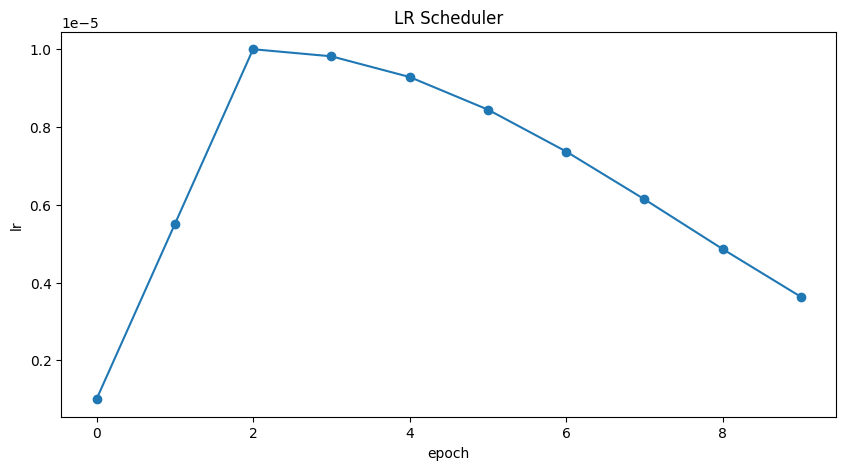

In [50]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# 💾 | Model Checkpointing

The following code will create a callback that will save the best checkpoint of the model during training, which we will use for inference in the submission.

In [51]:
ckpt_cb = keras.callbacks.ModelCheckpoint(f'best_model.weights.h5',
                                           monitor='val_loss',
                                          save_best_only=True,
                                          save_weights_only=True,
                                          mode='min')  # Get Model checkpoint callback

# 📏 | Metric

The metric for this competition is **Log Loss**. This metric can be expressed mathematically as,

$$
\text{Log Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left( y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right)
$$

where $ N $ is the number of samples, $ y_i $ is the true label, and $ p_i $ is the predicted probability of the sample belonging to the positive class.

Note that this metric is similar to categorical cross entropy widely used in classification tasks. Thus, we don't need to implement the loss from scratch. As the Keras library already has an implementation of this metric, we will simply use the metric to monitor performance of our model.


In [52]:
log_loss = keras.metrics.CategoricalCrossentropy(name="log_loss")

In [53]:
# Define input layers
inputs = {
    "token_ids": keras.Input(shape=(2, None), dtype=tf.int32, name="token_ids"),
    "padding_mask": keras.Input(shape=(2, None), dtype=tf.int32, name="padding_mask"),
}


# Extract token IDs and padding mask for response A and response B
token_ids_a = keras.layers.Lambda(lambda x: x[:, 0, :])(inputs["token_ids"])
token_ids_b = keras.layers.Lambda(lambda x: x[:, 1, :])(inputs["token_ids"])
padding_mask_a = keras.layers.Lambda(lambda x: x[:, 0, :])(inputs["padding_mask"])
padding_mask_b = keras.layers.Lambda(lambda x: x[:, 1, :])(inputs["padding_mask"])

# Create DeBERTaV3 backbone
backbone = keras_nlp.models.DebertaV3Backbone.from_preset(CFG.preset)
backbone.trainable = True

# Compute embeddings for response A and response B
embeddings_a = backbone({"token_ids": token_ids_a, "padding_mask": padding_mask_a})
embeddings_b = backbone({"token_ids": token_ids_b, "padding_mask": padding_mask_b})

# Extract the [CLS] token embeddings for both responses
cls_embedding_a = embeddings_a[:, 0, :]  # Shape: (batch_size, hidden_size)
cls_embedding_b = embeddings_b[:, 0, :]  # Shape: (batch_size, hidden_size)
combined_embeddings = keras.layers.Concatenate()([cls_embedding_a, cls_embedding_b])

# Classification head
x = keras.layers.Dense(512, activation="relu")(combined_embeddings)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(3, activation="softmax", name="classifier", dtype='float32')(x)

# Build and compile the model
model = keras.Model(inputs, outputs)
sample_batch = next(iter(train_ds.take(1)))
model(sample_batch[0])
# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy"),keras.metrics.SparseCategoricalCrossentropy(name="log_loss")],
)



# 🤖 | Modeling

The `KerasNLP` library provides various NLP model architectures such as `Bert`, `Roberta`, `DebertaV3`, and more. While this notebook focuses on `DebertaV3`, you can explore others in the [KerasNLP documentation](https://keras.io/api/keras_nlp/models/). For a deeper understanding, refer to the [getting started guide](https://keras.io/guides/keras_nlp/getting_started/).

Our approach utilizes `keras_nlp.models.DebertaV3Classifier` to process each prompt and response pair, generating output embeddings. We then concatenate these embeddings and pass them through a Pooling layer and a classifier to obtain logits, followed by a `softmax` function for the final output.

When dealing with multiple responses, we use a weight-sharing strategy. This means we provide the model with one response at a time along with the prompt `(P + R_A)`, `(P + R_B)`, etc., using the same model weights for all responses. After obtaining embeddings for all responses, we concatenate them and apply average pooling. Next, we use a `Linear/Dense` layer along with the `Softmax` function as the classifier for the final result. Providing all responses at once would increase text length and complicate model handling. Note that, in the classifier, we use 3 classes for `winner_model_a`, `winner_model_b`, and `draw` cases.

The diagram below illustrates this approach:

<div align="center">
    <img src="https://i.postimg.cc/g0gcvy3f/Kaggle-drawio.png">
</div>

From a coding perspective, note that we use the same model for all responses with shared weights, contrary to the separate models implied in the diagram.

### Model Summary

In [54]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer) │ (None, 2, None)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_ids (InputLayer)    │ (None, 2, None)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, None)           │              0 │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, None)           │              0 │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, None)           │              0 │ padding_mask[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, None)           │              0 │ token_ids[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deberta_v3_backbone       │ (None, None, 1024)     │    434,012,160 │ lambda_6[0][0],        │
│ (DebertaV3Backbone)       │                        │                │ lambda_4[0][0],        │
│                           │                        │                │ lambda_7[0][0],        │
│                           │                        │                │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 1024)           │              0 │ deberta_v3_backbone[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_3 (GetItem)      │ (None, 1024)           │              0 │ deberta_v3_backbone[1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 2048)           │              0 │ get_item_2[0][0],      │
│ (Concatenate)             │                        │                │ get_item_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │      1,049,088 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_50 (Dropout)      │ (None, 512)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 256)            │        131,328 │ dropout_50[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_51 (Dropout)      │ (None, 256)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 128)            │         32,896 │ dropout_51[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast_1 (Cast)             │ (None, 128)            │              0 │ dense_5[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier (Dense)        │ (None, 3)              │            387 │ cast_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 435,225,859 (1.62 GB)

 Trainable params: 435,225,859 (1.62 GB)

 Non-trainable params: 0 (0.00 B)

### Model Plot

In the model graph below, it may seem there are **four** inputs, but actually, there are **two** as discussed before. Our input consists of two parts, one for each response. However, for each input, we have `token_ids` and `padding_mask`, which makes it look like we have four inputs, but in reality, we have two inputs.

# 🚂 | Training

In [ ]:
# Start training the model
import os
import keras_nlp
print("KerasNLP version:", keras_nlp.__version__)


history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    validation_data=valid_ds,
    callbacks=[lr_cb, ckpt_cb]
)

KerasNLP version: 0.17.0
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning:

Converting sparse IndexedSlices to a dense Tensor with 131174400 elements. This may consume a large amount of memory.



6107/6107 ━━━━━━━━━━━━━━━━━━━━ 3213s 471ms/step - accuracy: 0.3649 - log_loss: 1.1528 - loss: 1.1528 - val_accuracy: 0.4710 - val_log_loss: 1.0434 - val_loss: 1.0434 - learning_rate: 1.0000e-06
Epoch 2/5
6107/6107 ━━━━━━━━━━━━━━━━━━━━ 2694s 441ms/step - accuracy: 0.4252 - log_loss: 1.0694 - loss: 1.0694 - val_accuracy: 0.4868 - val_log_loss: 1.0178 - val_loss: 1.0178 - learning_rate: 5.5000e-06
Epoch 3/5
6107/6107 ━━━━━━━━━━━━━━━━━━━━ 2599s 426ms/step - accuracy: 0.4769 - log_loss: 1.0242 - loss: 1.0242 - val_accuracy: 0.4444 - val_log_loss: 1.0762 - val_loss: 1.0762 - learning_rate: 1.0000e-05
Epoch 4/5
6107/6107 ━━━━━━━━━━━━━━━━━━━━ 2566s 420ms/step - accuracy: 0.5811 - log_loss: 0.8771 - loss: 0.8771 - val_accuracy: 0.4587 - val_log_loss: 1.1057 - val_loss: 1.1057 - learning_rate: 9.8177e-06
Epoch 5/5
2009/6107 ━━━━━━━━━━━━━━━━━━━━ 27:35 404ms/step - accuracy: 0.6372 - log_loss: 0.7790 - loss: 0.7790

In [ ]:
for i in range(5):
    print("Options:", train_texts[i])
    print("Label:", train_labels[i])

In [ ]:
for batch in train_ds.take(1):
    inputs, labels = batch
    print("Token IDs shape:", inputs['token_ids'].shape)
    print("Padding mask shape:", inputs['padding_mask'].shape)
    print("Labels shape:", labels.shape)


## Load Best Model

After training, let's load the weight with best result to get the best performance.

In [ ]:
# model.load_weights('/kaggle/working/best_model.weights.h5')

# 🧪 | Prediction

In [ ]:
# Build test dataset
test_texts = test_df.options.tolist()
test_ds = build_dataset(test_texts,
                         batch_size=min(len(test_df), CFG.batch_size),
                         shuffle=False)

In [ ]:
# Make predictions using the trained model on test data
test_preds = model.predict(test_ds, verbose=1)

# 📬 | Submission

Following code will prepare the submission file.

In [ ]:
sub_df = test_df[["id"]].copy()
sub_df[CFG.class_names] = test_preds.tolist()
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

# 🔭 | Future Directions

In this notebook, we've achieved a good score with a small model and modest token length. But there's plenty of room to improve. Here's how:

1. Try bigger models like `Deberta-Base` or `Deberta-Small`, or even LLMs like `Gemma`.
2. Increase max token length to reduce loss of data.
3. Use a five-fold cross-validation and ensemble to make the model robust and get better scores.
4. Add augmentation like shuffling response orders for more robust performance.
5. Train for more epochs.
6. Tune the learning rate scheduler.

# 📌 | Reference

* [LLM Science Exam: KerasCore + KerasNLP [TPU]](https://www.kaggle.com/code/awsaf49/llm-science-exam-kerascore-kerasnlp-tpu)
* [AES 2.0: KerasNLP Starter](https://www.kaggle.com/code/awsaf49/aes-2-0-kerasnlp-starter)